In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

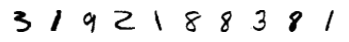

label: [3 1 9 2 1 8 8 3 8 1]
image data shape: (1, 28, 28)


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0), (1))])

trainset = datasets.MNIST(root='data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='data/', train=False, transform=transform)

# Visualize 10 image samples in MNIST dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
dataiter = iter(trainloader)
images, labels = dataiter.next()
# plot 10 sample images
_,ax = plt.subplots(1,10)
ax = ax.flatten()
iml = images[0].numpy().shape[1]
[ax[i].imshow(np.transpose(images[i].numpy(),(1,2,0)).reshape(iml,-1),cmap='Greys') for i in range(10)]
[ax[i].set_axis_off() for i in range(10)]
plt.show()
print('label:',labels[:10].numpy())
print('image data shape:',images[0].numpy().shape)

In [208]:
### define MLP
class MLP(nn.Module):
    def __init__(self, im_size=(28, 28), num_class=10, hidden_layer_specs=[256, 512, 1024], dropout_layer_specs=[0, 0, 0], drop_input=0.2):
        super(MLP, self).__init__()
        assert len(hidden_layer_specs) == (len(dropout_layer_specs))
        hidden_layer_specs = [im_size[0]*im_size[1]] + hidden_layer_specs
        layers = []
        if drop_input != 0:
            layers += [nn.Dropout(drop_input)]
        for i in range(len(hidden_layer_specs)-1):
            layers += [nn.Linear(hidden_layer_specs[i], hidden_layer_specs[i+1])]
            layers += [nn.ReLU()]
            if dropout_layer_specs[i] != 0:
                layers += [nn.Dropout(dropout_layer_specs[i])]     
        self.layers = nn.Sequential(*layers)
        self.head = nn.Linear(hidden_layer_specs[-1], num_class)

    def forward(self, x):
        assert len(x.shape)==4 # N x C x H x W
        x = x.view(x.shape[0], -1)
        x = self.layers(x)
        return self.head(x)

In [224]:
class MLPClassifier:
    def __init__(self, hidden_layer_specs=[256, 512, 1024], dropout_layer_specs=[0, 0, 0, 0], drop_input=0, batch_size=1024, max_epoch=10, lr=0.0002, weigth_decay=5e-4):
        # Wrap MLP model
        self.hidden_layer_specs = hidden_layer_specs
        self.droprates = dropout_layer_specs
        self.batch_size = batch_size
        self.max_epoch = max_epoch
        self.model = MLP(hidden_layer_specs=hidden_layer_specs, dropout_layer_specs=dropout_layer_specs, drop_input=drop_input)
        self.model.cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weigth_decay)
        self.loss_ = []
        self.test_accuracy = []
        self.test_error = []
        
    def fit(self, trainset, testset, verbose=True):
        # Training, make sure it's on GPU, otherwise, very slow...
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=self.batch_size, shuffle=True)
        testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
        X_test, y_test = iter(testloader).next()
        X_test = X_test.cuda()
        for epoch in range(self.max_epoch):
            running_loss = 0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.cuda(), labels.cuda()
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            self.loss_.append(running_loss / len(trainloader))
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, self.loss_[-1]))
            y_test_pred = self.predict(X_test).cpu().numpy()
            self.test_accuracy.append(np.mean(y_test.numpy() == y_test_pred))
            self.test_error.append(int(len(testset)*(1-self.test_accuracy[-1])))
            if verbose:
                print('Test error: {}; test accuracy: {}'.format(self.test_error[-1], self.test_accuracy[-1]))
        return self
    
    def predict(self, x):
        with torch.no_grad():
            # Used to keep all test errors after each epoch
            model = self.model.eval()
            outputs = model(x)
            _, pred = torch.max(outputs.data, 1)
            model = self.model.train()
            return pred
    
    def __str__(self):
        return 'Hidden layers: {}; dropout rates: {}'.format(self.hidden_layers, self.droprates)

In [225]:
hidden_layer_specs = [800, 1600] 

# Define networks
mlp1 = [MLPClassifier(hidden_layer_specs, dropout_layer_specs=[0, 0], max_epoch=500), 
        MLPClassifier(hidden_layer_specs, dropout_layer_specs=[0, 0.5], max_epoch=500),
        MLPClassifier(hidden_layer_specs, dropout_layer_specs=[0.25, 0.25], max_epoch=500),
        MLPClassifier(hidden_layer_specs, dropout_layer_specs=[0.2, 0.2], drop_input=0.2, max_epoch=500)]

[print(i.model) for i in mlp1];

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=1600, bias=True)
    (3): ReLU()
  )
  (head): Linear(in_features=1600, out_features=10, bias=True)
)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=800, bias=True)
    (1): ReLU()
    (2): Linear(in_features=800, out_features=1600, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
  )
  (head): Linear(in_features=1600, out_features=10, bias=True)
)
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=800, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=800, out_features=1600, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
  )
  (head): Linear(in_features=1600, out_features=10, bias=True)
)
MLP(
  (layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=80

In [226]:
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(trainset, testset,verbose=True) for mlp in mlp1]

# Save torch models
for ind, mlp in enumerate(mlp1):
    torch.save(mlp.model, 'mnist_mlp1_'+str(ind)+'.pth')
    # Prepare to save errors
    mlp.test_error = list(map(str, mlp.test_error))

# Save test errors to plot figures
open("mlp1_test_errors.txt","w").write('\n'.join([','.join(mlp.test_error) for mlp in mlp1])) 

# Load saved models to CPU
mlp1_models = [torch.load('mnist_mlp1_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1,2,3]]

# Load saved test errors to plot figures.
mlp1_test_errors = [error_array.split(',') for error_array in open("mlp1_test_errors.txt","r").read().split('\n')]
mlp1_test_errors = np.array(mlp1_test_errors,dtype='f')

Epoch 1 loss: 1.026245411169731
Test error: 984; test accuracy: 0.9016
Epoch 2 loss: 0.31534513022940036
Test error: 763; test accuracy: 0.9237
Epoch 3 loss: 0.2505800057265718
Test error: 645; test accuracy: 0.9355
Epoch 4 loss: 0.2087323784323062
Test error: 570; test accuracy: 0.943
Epoch 5 loss: 0.17956578403206194
Test error: 476; test accuracy: 0.9523
Epoch 6 loss: 0.15538953131033204
Test error: 416; test accuracy: 0.9583
Epoch 7 loss: 0.13633006331274064
Test error: 381; test accuracy: 0.9619
Epoch 8 loss: 0.12264397513058226
Test error: 346; test accuracy: 0.9653
Epoch 9 loss: 0.11163999809552047
Test error: 324; test accuracy: 0.9675
Epoch 10 loss: 0.10148355958320326
Test error: 310; test accuracy: 0.969
Epoch 11 loss: 0.09320364791457936
Test error: 309; test accuracy: 0.9691
Epoch 12 loss: 0.08662697912777885
Test error: 270; test accuracy: 0.973
Epoch 13 loss: 0.07967597991228104
Test error: 272; test accuracy: 0.9727
Epoch 14 loss: 0.07407824966614529
Test error: 254; te

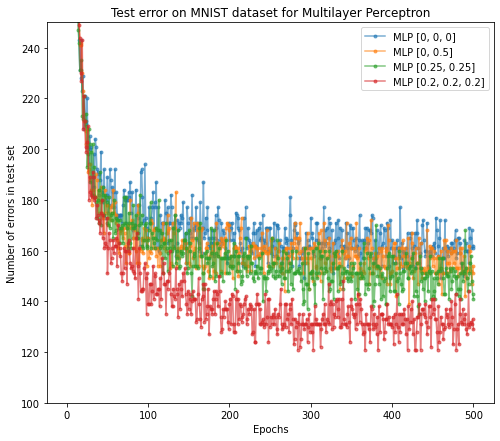

In [230]:
labels = [f'MLP {[0, 0, 0]}', 
          f'MLP {[0, 0.5]}',
          f'MLP {[0.25, 0.25]}',
          f'MLP {[0.2, 0.2, 0.2]}',]

plt.figure(figsize=(8, 7))
for i, r in enumerate(mlp1_test_errors):
    plt.plot(range(1, len(r)+1), r, '.-', label=labels[i], alpha=0.6);
plt.ylim([100, 250]);
plt.legend(loc=1);
plt.xlabel('Epochs');
plt.ylabel('Number of errors in test set');
plt.title('Test error on MNIST dataset for Multilayer Perceptron')
plt.show()

In [231]:
from skimage import transform

In [264]:
def predict_class(model, X):
    model = model.eval()
    outputs = model(X)
    _, pred = torch.max(outputs.data, 1)
    model = model.train()
    return pred.numpy()

def predict_out(model, X):
    logits = model(X)
    outputs = F.softmax(logits, dim=1)
    return logits, outputs

def predict(model, X, T=1000):
    with torch.no_grad():
        standard_pred = predict_class(model, X)
        standard_logits, standard_outputs = predict_out(model, X)
        y1 = []
        y2 = []
        for _ in range(T):
            _y1 = model(X)
            _y2 = F.softmax(_y1, dim=1)
            y1.append(_y1.data.numpy())
            y2.append(_y2.data.numpy())
        return standard_pred, standard_logits, standard_outputs, np.array(y1), np.array(y2)

In [249]:
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)
X_test, y_test = iter(testloader).next()
X_test_arr = X_test.numpy()

Predictions: [4 4 4 4 4 9 9 9 9 9 9 9 0 5 5]


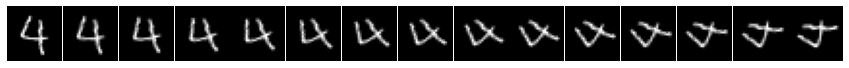

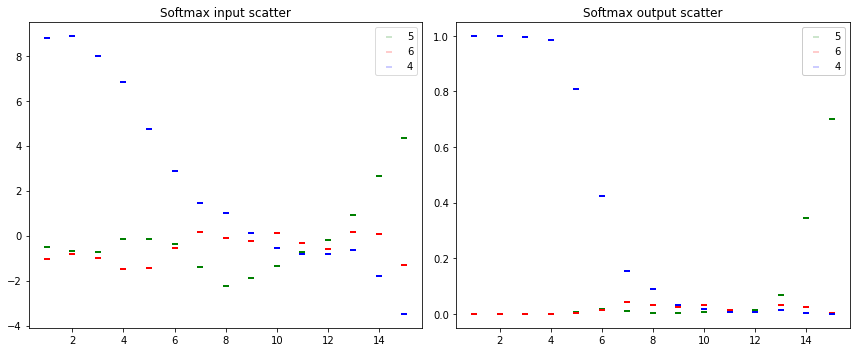

In [280]:
sample_id = 24
model = mlp1_models[0]
# X1 = np.array([transform.rotate(X_test_arr[0].squeeze(), i, order=3, preserve_range=True) for i in range(40, 130, 6)])
X1 = np.array([transform.rotate(X_test_arr[sample_id].squeeze(), i, order=3, preserve_range=True) for i in range(0, 90, 6)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(15, 1))

gs = gridspec.GridSpec(1, 15)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

# Need to flatten X1 before feeding into MLP
y1_pred, y1_logits, y1_outputs, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 5].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='5');
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 6].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='6');
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 4].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='4');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 5].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='5');
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 6].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='6');
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 4].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='4');
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();

Predictions: [5 5 5 5 5 5 5 5 8 6 4 4 4 4 4]


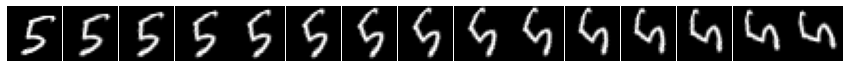

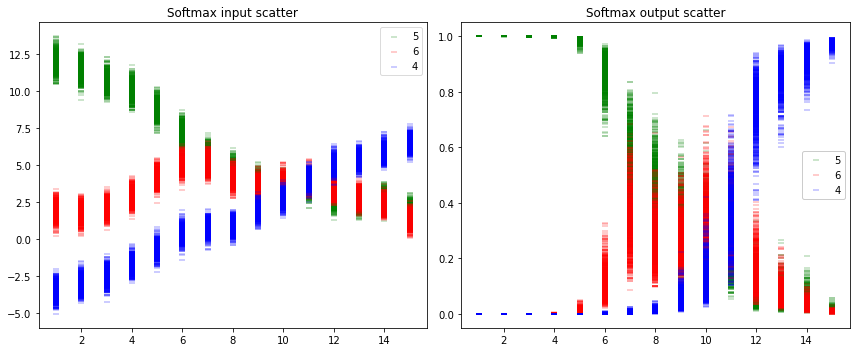

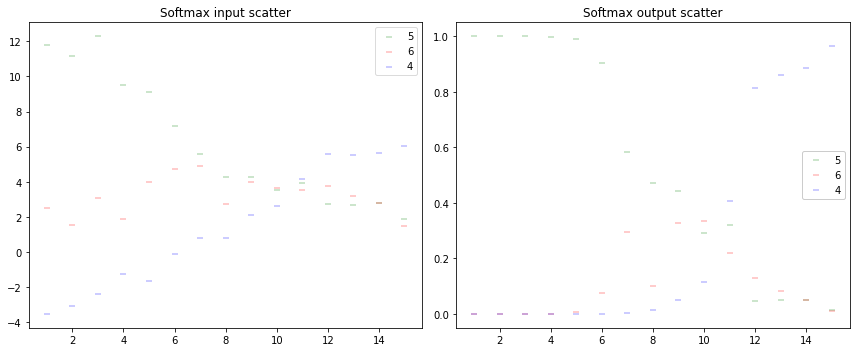

In [279]:
model = mlp1_models[1]
# X1 = np.array([transform.rotate(X_test_arr[0].squeeze(), i, order=3, preserve_range=True) for i in range(40, 130, 6)])
X1 = np.array([transform.rotate(X_test_arr[sample_id].squeeze(), i, order=3, preserve_range=True) for i in range(0, 90, 6)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(15, 1))

gs = gridspec.GridSpec(1, 15)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

# Need to flatten X1 before feeding into MLP
y1_pred, y1_logits, y1_outputs, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 5].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='5');
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 6].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='6');
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 4].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='4');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 5].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='5');
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 6].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='6');
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 4].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='4');
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, 5].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='5');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, 6].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='6');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, 4].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='4');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, 5].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='5');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, 6].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='6');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, 4].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='4');
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();

Predictions: [4 4 4 4 4 4 9 9 9 9 7 7 7 7 7]


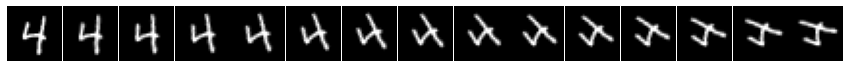

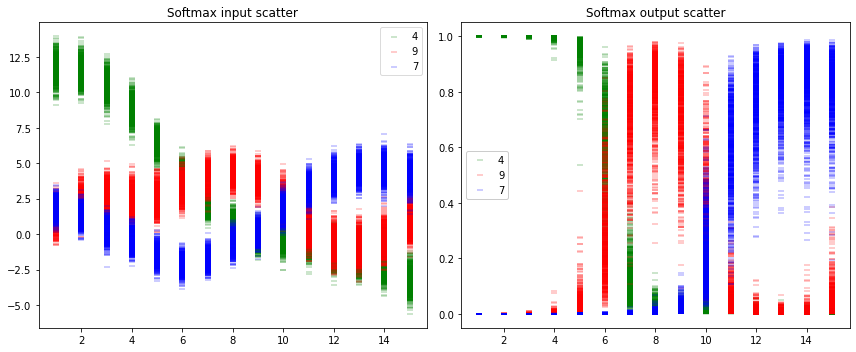

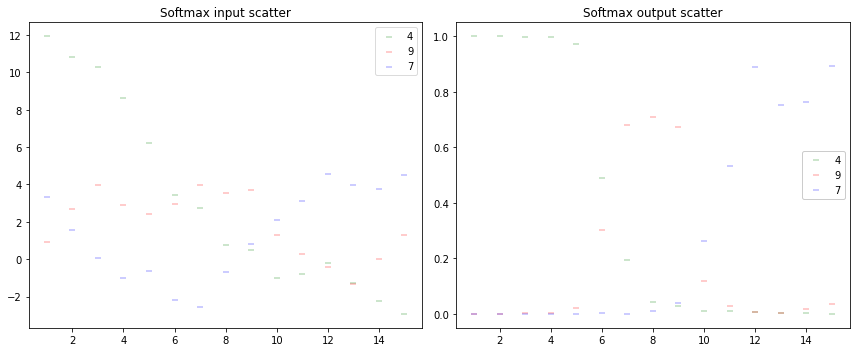

In [270]:
model = mlp1_models[2]
# X1 = np.array([transform.rotate(X_test_arr[0].squeeze(), i, order=3, preserve_range=True) for i in range(40, 130, 6)])
X1 = np.array([transform.rotate(X_test_arr[sample_id].squeeze(), i, order=3, preserve_range=True) for i in range(0, 90, 6)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(15, 1))

gs = gridspec.GridSpec(1, 15)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

# Need to flatten X1 before feeding into MLP
y1_pred, y1_logits, y1_outputs, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 4].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='4');
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 9].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='9');
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, 7].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='7');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 4].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='4');
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 9].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='9');
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, 7].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='7');
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, 4].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='4');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, 9].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='9');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, 7].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='7');
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, 4].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label='4');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, 9].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label='9');
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, 7].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label='7');
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();

Predictions: [3 3 3 3 3 7 7 7 7 9 9 7 7 7 7]


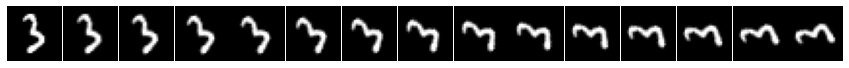

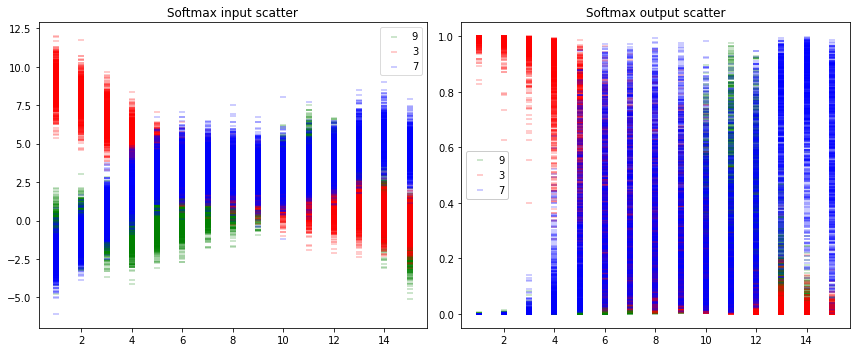

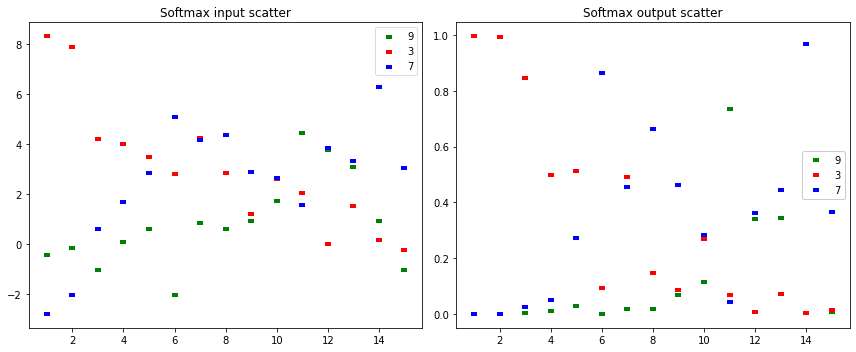

In [309]:
sample_id = 44
model = mlp1_models[3]
# X1 = np.array([transform.rotate(X_test_arr[0].squeeze(), i, order=3, preserve_range=True) for i in range(40, 130, 6)])
X1 = np.array([transform.rotate(X_test_arr[sample_id].squeeze(), i, order=3, preserve_range=True) for i in range(0, 90, 6)])
X1 = X1.reshape(X1.shape[0], 1, X1.shape[1], X1.shape[2])

plt.figure(figsize=(15, 1))

gs = gridspec.GridSpec(1, 15)
gs.update(wspace=0, hspace=0)

for i in range(len(X1)):
    plt.subplot(gs[i])
    plt.imshow(X1.squeeze()[i], cmap='gray');
    plt.axis('off');

# Need to flatten X1 before feeding into MLP
y1_pred, y1_logits, y1_outputs, y1_si, y1_so = predict(model, torch.from_numpy(X1))
print('Predictions: {}'.format(y1_pred))
predicted_digits = list(set(y1_pred))
assert len(predicted_digits) >= 3

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, predicted_digits[0]].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label=str(predicted_digits[0]));
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, predicted_digits[1]].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label=str(predicted_digits[1]));
plt.scatter(np.tile(np.arange(1, 16), y1_si.shape[0]), y1_si[:, :, predicted_digits[2]].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label=str(predicted_digits[2]));
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, predicted_digits[0]].flatten(), \
            color='g', marker='_', linewidth=2, alpha=0.2, label=str(predicted_digits[0]));
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, predicted_digits[1]].flatten(), \
            color='r', marker='_', linewidth=2, alpha=0.2, label=str(predicted_digits[1]));
plt.scatter(np.tile(np.arange(1, 16), y1_so.shape[0]), y1_so[:, :, predicted_digits[2]].flatten(), \
            color='b', marker='_', linewidth=2, alpha=0.2, label=str(predicted_digits[2]));
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, predicted_digits[0]].flatten(), \
            color='g', marker='_', linewidth=4, alpha=1, label=str(predicted_digits[0]));
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, predicted_digits[1]].flatten(), \
            color='r', marker='_', linewidth=4, alpha=1, label=str(predicted_digits[1]));
plt.scatter(np.tile(np.arange(1, 16), 1), y1_logits[:, predicted_digits[2]].flatten(), \
            color='b', marker='_', linewidth=4, alpha=1, label=predicted_digits[2]);
plt.title('Softmax input scatter');
plt.legend(framealpha=0.7);

plt.subplot(1, 2, 2)
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, predicted_digits[0]].flatten(), \
            color='g', marker='_', linewidth=4, alpha=1, label=str(predicted_digits[0]));
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, predicted_digits[1]].flatten(), \
            color='r', marker='_', linewidth=4, alpha=1, label=str(predicted_digits[1]));
plt.scatter(np.tile(np.arange(1, 16), 1), y1_outputs[:, predicted_digits[2]].flatten(), \
            color='b', marker='_', linewidth=4, alpha=1, label=str(predicted_digits[2]));
plt.title('Softmax output scatter');
plt.legend(framealpha=1);

plt.tight_layout();